# Classificação multiclasses

Baseado em F. Chollet (2018).

Diferentemente das classificações que fizemos até aqui, sempre binárias (positivo/negativo; spam/ham...), existem classificações de dados em um número $n$ de classes (ou categorias).

Neste exercício, usaremos um conjunto de dados de notícias da agência Reuters para uma classificação de assuntos. Há 46 categorias de assuntos possíveis, todas elas mutuamente excludentes, isto é, para cada notícia, existe somente uma categoria correta.

O corpus traz 8982 notícias para treinamento e outras 2246 para teste. Cada categoria tem pelo menos 10 ocorrências no treinamento.

#Carregamento dos dados e das etiquetas

In [1]:
from keras.datasets import reuters

(dados_treino, etiquetas_treino), (dados_teste, etiquetas_teste) = reuters.load_data(num_words=10000)  # Carregar só as 10.000 palavras mais frequentes

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
### Conferindo...

print(len(dados_treino), len(dados_teste))
print(dados_treino[0])

8982 2246
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [4]:
### Só para conferir... ###

# Cria um dicionário com a forma {palavra: índice}
indice_de_palavra = reuters.get_word_index()
print('O índice de "after" é: ', indice_de_palavra['after'])

# Cria um dicionário que permite mapear uma palavra em função de um valor numérico (seu índice)
palavra_de_indice = dict([(value, key) for (key, value) in indice_de_palavra.items()])
print('A palavra de índice 100 é: ', palavra_de_indice[100])

# Gera uma string com o vetor das palavras decodificadas em uma dada resenha (0, no caso)
# Os três primeiros índices são reservados nesse dataset ("padding", "início de sequência" e "desconhecido")
# Lembre-se: o método .get() substitui chaves desconhecidas por um valor default ('<?>', no caso)
noticia_decodificada = ' '.join([palavra_de_indice.get(i-3, '<?>') for i in dados_treino[0]])
print(noticia_decodificada)

557056/550378 [==============================] - 0s 0us/step
O índice de "after" é:  89
A palavra de índice 100 é:  group
<?> <?> <?> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [15]:
# As etiquetas são números inteiros no intervalo [0..45]
print(etiquetas_treino[0])
print(min(etiquetas_treino), max(etiquetas_treino))

3
0 45


# Codificação em binários

Codificação (encoding) dos vetores de inteiros em matrizes binárias de índices de termos em documentos.


In [5]:
import numpy as np

def binarizar(matriz_int, dim=10000):
    binarizado = np.zeros((len(matriz_int), dim))

    for e, vetor in enumerate(matriz_int):
        binarizado[e, vetor] = 1.

    return binarizado

# Conversão em binários dos testos das resenhas (variável X)
treino_x = binarizar(dados_treino)
teste_x = binarizar(dados_teste)

In [6]:
treino_x[0]  # Só para conferir...

array([0., 1., 1., ..., 0., 0., 0.])

In [38]:
# Vetorização das etiquetas de assuntos [0..45]. Variável Y.

treino_y = binarizar(etiquetas_treino, dim=46)  # Repare o número de dimensões (46)
teste_y = binarizar(etiquetas_teste, dim=46)

In [39]:
print(len(treino_x), len(treino_y), len(teste_x), len(teste_y))  # Conferindo...

8982 8982 2246 2246


In [25]:
treino_y[0]  # Conferindo...

(8982, 46)

# Criação do modelo de rede

Partição dos dados de treinamento em (1) validação e (2) treinamento parcial, tanto X (resenhas) quanto Y (etiquetas).

In [40]:
valid_x = treino_x[:1000]
treino_x_parcial = treino_x[1000:]
valid_y = treino_y[:1000] 
treino_y_parcial = treino_y[1000:]

Importação dos módulos e definição da arquitetura da rede.

Desta vez, para tentar representar melhor as 46 classes, vamos aumentar o tamanho das camadas internas.

O vetor de saída terá 46 dimensões, uma para cada classe possível.

A função de ativação na saída é a softmax, que distribui a probabilidade de classficiação entre as 46 classes (isto é, juntas, somam 1).

In [41]:
from keras import models 
from keras import layers

modelo = models.Sequential() 
modelo.add(layers.Dense(64, activation='relu', input_shape=(10000,))) 
modelo.add(layers.Dense(64, activation='relu')) 
modelo.add(layers.Dense(46, activation='softmax'))

Compilação do modelo.

In [42]:
# A diferença dos parâmetros de compilação que usaremos aqui por relação à 
# classificação binária está na função de perda escolhida.
# Ainda é a entropia cruzada, boa para classificação probabilística, mas,
# desta vez, é a "categorial", não a binária.

modelo.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['acc'])

Treinamento do modelo compilado.

In [43]:
historia = modelo.fit(treino_x_parcial, 
                    treino_y_parcial, 
                    epochs=20, 
                    batch_size=512, 
                    validation_data=(valid_x, valid_y))

Epoch 1/20
16/16 [==============================] - 1s 67ms/step - loss: 3.5573 - acc: 0.2873 - val_loss: 2.5043 - val_acc: 0.4690
Epoch 2/20
16/16 [==============================] - 1s 54ms/step - loss: 2.1486 - acc: 0.5701 - val_loss: 1.6211 - val_acc: 0.6650
Epoch 3/20
16/16 [==============================] - 1s 47ms/step - loss: 1.3905 - acc: 0.7094 - val_loss: 1.2735 - val_acc: 0.7250
Epoch 4/20
16/16 [==============================] - 1s 45ms/step - loss: 1.0610 - acc: 0.7717 - val_loss: 1.1234 - val_acc: 0.7630
Epoch 5/20
16/16 [==============================] - 1s 45ms/step - loss: 0.8009 - acc: 0.8318 - val_loss: 1.0236 - val_acc: 0.7850
Epoch 6/20
16/16 [==============================] - 1s 45ms/step - loss: 0.6436 - acc: 0.8675 - val_loss: 0.9571 - val_acc: 0.8050
Epoch 7/20
16/16 [==============================] - 1s 55ms/step - loss: 0.4785 - acc: 0.9029 - val_loss: 0.9066 - val_acc: 0.8150
Epoch 8/20
16/16 [==============================] - 1s 47ms/step - loss: 0.3677 - a

Exibição da evolução da perda no treinamento e na validação.

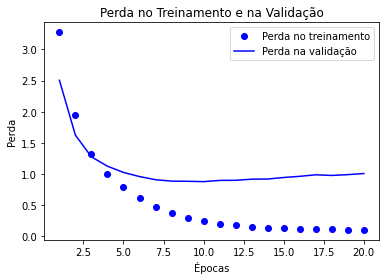

In [44]:
import matplotlib.pyplot as plt

dic_historia = historia.history  # dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
perda = dic_historia['loss'] 
perda_valid = dic_historia['val_loss']

acuracia = dic_historia['acc']
epocas = range(1, len(acuracia) + 1)

plt.plot(epocas, perda, 'bo', label='Perda no treinamento')  # “bo” = pontilhado azul
plt.plot(epocas, perda_valid, 'b', label='Perda na validação')  # “b” = linha contínua azul
plt.title('Perda no Treinamento e na Validação') 
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

Exibição da evolução da acurácia no teste e na validação.

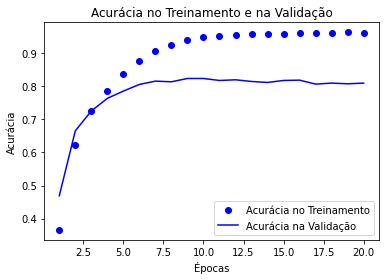

In [45]:
plt.clf()  # Limpa a figura

acuracia_treino = dic_historia['acc'] 
acuracia_valid = dic_historia['val_acc']

plt.plot(epocas, acuracia_treino, 'bo', label='Acurácia no Treinamento') 
plt.plot(epocas, acuracia_valid, 'b', label='Acurácia na Validação')
plt.title('Acurácia no Treinamento e na Validação') 
plt.xlabel('Épocas') 
plt.ylabel('Acurácia') 
plt.legend()

plt.show()

# Introdução de um gargalo na rede

Vamos "esmagar" uma camada da rede, reduzindo propositadamente seu tamanho para, em seguida, avaliar os resultados.

In [78]:
from keras import models 
from keras import layers

modelo = models.Sequential() 
modelo.add(layers.Dense(64, activation='relu', input_shape=(10000,))) 
modelo.add(layers.Dense(4, activation='relu'))  # Camada esmagada!!!
modelo.add(layers.Dense(46, activation='softmax'))

In [79]:
### O resto fica igual...

modelo.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['acc'])

historia = modelo.fit(treino_x_parcial, 
                    treino_y_parcial, 
                    epochs=20, 
                    batch_size=512, 
                    validation_data=(valid_x, valid_y))

Epoch 1/20
16/16 [==============================] - 1s 66ms/step - loss: 3.7949 - acc: 0.0448 - val_loss: 3.6215 - val_acc: 0.0220
Epoch 2/20
16/16 [==============================] - 1s 51ms/step - loss: 3.5411 - acc: 0.0290 - val_loss: 3.3550 - val_acc: 0.0470
Epoch 3/20
16/16 [==============================] - 1s 52ms/step - loss: 3.2374 - acc: 0.0806 - val_loss: 3.0337 - val_acc: 0.1380
Epoch 4/20
16/16 [==============================] - 1s 54ms/step - loss: 2.8449 - acc: 0.3117 - val_loss: 2.6163 - val_acc: 0.5300
Epoch 5/20
16/16 [==============================] - 1s 54ms/step - loss: 2.3558 - acc: 0.5993 - val_loss: 2.1370 - val_acc: 0.6090
Epoch 6/20
16/16 [==============================] - 1s 55ms/step - loss: 1.8709 - acc: 0.6461 - val_loss: 1.7990 - val_acc: 0.6280
Epoch 7/20
16/16 [==============================] - 1s 54ms/step - loss: 1.5211 - acc: 0.6682 - val_loss: 1.6383 - val_acc: 0.6390
Epoch 8/20
16/16 [==============================] - 1s 54ms/step - loss: 1.4077 - a

Vamos retreinar o modelo, desafogando o gargalo e inserindo o EarlyStopping por conveniência.

In [80]:
from tensorflow.keras import callbacks

modelo = models.Sequential() 
modelo.add(layers.Dense(64, activation='relu', input_shape=(10000,))) 
modelo.add(layers.Dense(64, activation='relu')) 
modelo.add(layers.Dense(46, activation='softmax'))

modelo.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['acc'])

aprendeu_parou = callbacks.EarlyStopping(
    min_delta=0.001,  # aprendizado mínimo (resultados menores não contarão como aprendizado)
    patience=10,  # por quantas épocas insistir?
    restore_best_weights=True)

historia = modelo.fit(treino_x_parcial, 
                    treino_y_parcial, 
                    epochs=300, 
                    batch_size=512, 
                    validation_data=(valid_x, valid_y),
                    callbacks=[aprendeu_parou])

Epoch 1/300
16/16 [==============================] - 1s 57ms/step - loss: 3.6106 - acc: 0.2821 - val_loss: 2.6829 - val_acc: 0.5500
Epoch 2/300
16/16 [==============================] - 1s 55ms/step - loss: 2.2992 - acc: 0.5946 - val_loss: 1.6483 - val_acc: 0.6710
Epoch 3/300
16/16 [==============================] - 1s 55ms/step - loss: 1.4081 - acc: 0.7185 - val_loss: 1.2455 - val_acc: 0.7290
Epoch 4/300
16/16 [==============================] - 1s 54ms/step - loss: 1.0498 - acc: 0.7724 - val_loss: 1.0971 - val_acc: 0.7720
Epoch 5/300
16/16 [==============================] - 1s 51ms/step - loss: 0.8020 - acc: 0.8292 - val_loss: 0.9972 - val_acc: 0.7930
Epoch 6/300
16/16 [==============================] - 1s 46ms/step - loss: 0.6215 - acc: 0.8706 - val_loss: 0.9387 - val_acc: 0.8070
Epoch 7/300
16/16 [==============================] - 1s 44ms/step - loss: 0.4859 - acc: 0.8990 - val_loss: 0.8950 - val_acc: 0.8140
Epoch 8/300
16/16 [==============================] - 1s 52ms/step - loss: 0.

# Avaliação

In [81]:
avaliacao = modelo.evaluate(teste_x, teste_y)

71/71 [==============================] - 0s 2ms/step - loss: 0.9487 - acc: 0.7894


In [82]:
print('Acurácia na avaliação: ', avaliacao[1], '\nPerda: ', avaliacao[0])

Acurácia na avaliação:  0.7894033789634705 
Perda:  0.9487050175666809


# Previsões (etiquetagens feitas pelo modelo)

In [77]:
previsoes = modelo.predict(teste_x)
len(previsoes)

2246

In [60]:
# Quantas são as classes possíveis para uma notícia qualquer?
previsoes[0].shape

(46,)

In [61]:
# Soma das probabilidades de todas as classes
sum(previsoes[0])

0.9999999892269436

In [63]:
# Qual a classe estimada para uma dada notícia?
# Note que o que está sendo buscado é o índice (i.e., posição no vetor de saída)
# da classe com maior probabilidade

np.argmax(previsoes[0])  

3

In [66]:
# E qual foi exatamente a probabilidade calculada para essa classe "campeã"?
previsoes[0][3]

0.99286824

# Tarefa: clusterização de assuntos

As notícias do conjunto de testes foram classificadas em 46 assuntos.

Agora, você deve implementar: 

1. Uma função que agrupe em listas as notícias divididas por assunto (para cada assunto haverá uma lista de notícias).

2. Uma função que receba um número qualquer correspondente à etiqueta de assunto e mostre o texto legível (não os vetores!) de três notícias quaisquer classificadas sob esse assunto.

3. Aqui está a lista dos 46 assuntos do corpus Reuters:

In [83]:
assuntos = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [84]:
len(assuntos)

46